# Backpropagation Lab





In [1]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import sys

## 1. (40%) Correctly implement and submit your own code for the backpropagation algorithm. 

## Code requirements 
- Ability to create a network structure with at least one hidden layer and an arbitrary number of nodes.
- Random weight initialization with small random weights with mean of 0 and a variance of 1.
- Use Stochastic/On-line training updates: Iterate and update weights after each training instance (i.e. do not attempt batch updates)
- Implement a validation set based stopping criterion.
- Shuffle training set at each epoch.
- Option to include a momentum term

You may use your own random train/test split or use the scikit-learn version if you want.

Use your Backpropagation algorithm to solve the Debug data. We provide you with several parameters, and you should be able to replicate our results every time. When you are confident it is correct, run your script on the Evaluation data with the same parameters, and print your final weights.

In [2]:
class MLPClassifier(BaseEstimator,ClassifierMixin):

    def __init__(self,lr, momentum, shuffle,hidden_layer_widths, Deterministic, random_weights, binaryClassification):
        """ Initialize class with chosen hyperparameters.

        Args:
            lr (float): A learning rate / step size.
            shuffle(boolean): Whether to shuffle the training data each epoch. DO NOT SHUFFLE for evaluation / debug datasets.
            momentum(float): The momentum coefficent 
        Optional Args (Args we think will make your life easier):
            hidden_layer_widths (list(int)): A list of integers which defines the width of each hidden layer if hidden layer is none do twice as many hidden nodes as input nodes.
        Example:
            mlp = MLPClassifier(lr=.2,momentum=.5,shuffle=False,hidden_layer_widths = [3,3]),  <--- this will create a model with two hidden layers, both 3 nodes wide
        """
        self.hidden_layer_widths = hidden_layer_widths
        self.lr = lr
        self.momentum = momentum
        self.shuffle = shuffle
        self.deterministic=Deterministic
        self.random_weights=random_weights
        self.weights=None
        self.delta_weights=None
        self.binaryClassification=binaryClassification
        self.x_valid=None
        self.y_valid=None
        self.x_test=None
        self.y_test=None


    def fit(self, X, y, output_size, initial_weights=None):
        """ Fit the data; run the algorithm and adjust the weights to find a good solution

        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets
            y (array-like): A 2D numpy array with the training targets
        Optional Args (Args we think will make your life easier):
            initial_weights (array-like): allows the user to provide initial weights
        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)

        """        
        self.input_size=X.shape[1]
        self.output_size=output_size
        if self.weights is None:
            self.initialize_weights()
            self.delta_weights=self.get_zero_weights()
        if self.deterministic:
            self.epochs=10
        else:
            self.epochs=sys.maxsize
            
        self.epoch_count=0    
        
        curr_valid_score = -1
        valid_count=0
        self.mse_training=[]
        self.mse_valid=[]
        self.accuracy_train=[]
        self.accuracy_valid=[]
                
        for _ in range(self.epochs):

            curr_delta_weights=[]
            for i in range(y.shape[0]):
                input_x = np.insert(X[i], len(X[i]), 1) # Add the bias of 1
                
                # Forwarding
                nets = [] 
                outs = [] 
                for num_layer in range(len(self.weights)):
                    if num_layer == 0:
                        net = self.get_nets(input_x, num_layer)
                    else:
                        net = self.get_nets(out, num_layer)                    
                    nets.append(net) 
                    out = self.activation_sigmoid(net)
                    if num_layer != len(self.weights)-1:
                        out.append(1) # bias
                    outs.append(out)
                    
                # get the output error
                output_out = outs[-1] # 1-d array
                output_out = np.array(output_out)                
                temp_errors=[]
                input_target = y[i] # 1-d array
                output_error = (input_target-output_out)*output_out*(1-output_out)
                
                # Backward
                errors = []
                self.get_errors(errors, output_error, outs)
                self.update_weights(errors, outs, input_x)                
                
            self.epoch_count += 1 
            
            # Debug and Eval model do not go through here
            if self.x_valid is not None:
                valid_score = self.score(self.x_valid, self.y_valid)
                
                pred_training = self.predict(X) # prediction using current weight
                self.mse_training.append(mean_squared_error(self.inverse_transform(y), pred_training))
                self.mse_valid.append(mean_squared_error(self.inverse_transform(self.y_valid), self.predict(self.x_valid)))
                self.accuracy_train.append(self.score(self.x_test, self.y_test))
                self.accuracy_valid.append(valid_score)
                
                if curr_valid_score < valid_score:
                    curr_valid_score = valid_score  
                    valid_count = 0
                    self.curr_best_weight = self.weights.copy()
                if valid_score <= curr_valid_score:
                    valid_count += 1

                if valid_count == 10:
                    print("done")
                    self.weights = self.curr_best_weight
                    break
            if self.shuffle:
                X,y=self._shuffle_data(X,y)      
        return self
    
    def update_weights(self, errors, outs, input_x):
        err = errors.copy()
        err.reverse()
        out = outs.copy()
        out.insert(0, input_x)
        del out[-1]
        
        for num_layer in range(len(self.weights)):
            w = self.weights[num_layer]
            e = err[num_layer]
            o = out[num_layer]
            
            temp_delta=[]
            curr_delta = self.delta_weights[num_layer]
            for i in range(len(o)):
                temp=[]
                for j in range(len(e)):
                    v = self.lr*e[j]*o[i] 
                    m = self.momentum*curr_delta[i][j]
                    temp.append(v+m)
                temp_delta.append(temp)
            self.weights[num_layer] = self.weights[num_layer] + np.array(temp_delta) 
            self.delta_weights[num_layer] = temp_delta

    def get_errors(self, errors, output_error, outs):
        errors.append(output_error.tolist())
        w = self.weights.copy()
        w = w.tolist()
        w.reverse()
        o_nodes = outs.copy()
        o_nodes.reverse()
        del o_nodes[0] 
        num_layers = len(self.weights)
        for layer in range(num_layers-1):
            error=[]
            prev_errors = errors[-1]
            curr_outs = o_nodes[layer]
            weight = w[layer]
            for i in range(len(curr_outs)-1):
                s = 0
                for j in range(len(prev_errors)):
                    s = s + prev_errors[j]*weight[i][j]
                e = s*self.get_der_sig(curr_outs[i])
                error.append(e)
            errors.append(error)        
    
    def get_der_sig(self, value):
        return value*(1-value)
   
    def activation_sigmoid(self, net):
        outs=[]
        for i in range(len(net)):
            val = 1.0/(1.0 + np.exp(-net[i]))
            outs.append(val)
        return outs
    
    def get_nets(self, x, num_layer):
        num_nodes = self.weights[num_layer].shape[1]
        nets = []
        weight_layer = self.weights[num_layer]
        for i in range(num_nodes):
            col = weight_layer[:,i]  
            dot_product = np.dot(x, col)
            nets.append(dot_product)
        return nets

    def predict(self, X):
        """ Predict all classes for a dataset X
        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets
        Returns:
            array, shape (n_samples,)
                Predicted target values per element in X.
        """
        preds=[]
        for i in range(X.shape[0]):
            x = np.insert(X[i], len(X[i]), 1)
            nets = [] 
            outs = []
            for num_layer in range(len(self.weights)):
                if num_layer == 0:
                    net = self.get_nets(x, num_layer)
                else:
                    net = self.get_nets(out, num_layer)
                nets.append(net)  
                out = self.activation_sigmoid(net)
                
                if num_layer != len(self.weights)-1:
                    out.append(1) # bias
                outs.append(out)
                
            output_out = outs[-1] # 1-d array
            output_out = np.array(output_out)
            index = output_out.argmax()
            preds.append(index)
        return preds
            
              
    
    def get_zero_weights(self):
        self.layer_size = 2 + len(self.hidden_layer_widths)
        self.node_size_list = [self.input_size + 1] # input nodes + bias
        for i in range(len(self.hidden_layer_widths)):
            self.node_size_list.append(self.hidden_layer_widths[i] + 1)
        if self.binaryClassification:
            self.node_size_list.append(self.output_size+1)
        else:
            self.node_size_list.append(self.output_size)
        weights = np.empty(self.layer_size-1, dtype=np.ndarray)
                
        for i in range(len(self.node_size_list) - 1):
            
            if i == len(self.node_size_list)-2:
                x=self.node_size_list[i]
                y=self.node_size_list[i+1]
            else:
                x=self.node_size_list[i]
                y=self.node_size_list[i+1]-1
            
            weights[i]=np.zeros((x,y))
            
        return weights
    
        

    def initialize_weights(self):
        """ Initialize weights for perceptron. Don't forget the bias!

        Returns:

        """
        if self.random_weights:
            self.layer_size = 2 + len(self.hidden_layer_widths)
            self.node_size_list = [self.input_size + 1] # input nodes + bias
            for i in range(len(self.hidden_layer_widths)):
                self.node_size_list.append(self.hidden_layer_widths[i] + 1)
            if self.binaryClassification:
                self.node_size_list.append(self.output_size+1)
            else:
                self.node_size_list.append(self.output_size)
            weights = np.empty(self.layer_size-1, dtype=np.ndarray)
                
            for i in range(len(self.node_size_list) - 1):
            
                if i == len(self.node_size_list)-2:
                    x=self.node_size_list[i]
                    y=self.node_size_list[i+1]
                else:
                    x=self.node_size_list[i]
                    y=self.node_size_list[i+1]-1
            
                weights[i]=np.random.uniform(-1,1,(x,y))
            self.weights = weights
        else:
            # random zeros
            self.weights = self.get_zero_weights()
            
        return [0]
    
    def inverse_transform(self, y):
        temp=[]
        for i in range(y.shape[0]):
            for j in range(y.shape[1]):
                if y[i][j] == 1:
                    temp.append(j)
        return temp

    def score(self, X, y):
        """ Return accuracy of model on a given dataset. Must implement own score function.

        Args:
            X (array-like): A 2D numpy array with data, excluding targets
            y (array-like): A 2D numpy array with targets

        Returns:
            score : float
                Mean accuracy of self.predict(X) wrt. y.
        """
        preds = self.predict(X)
        temp = self.inverse_transform(y)
        return self.get_num_match(preds, temp) / len(temp)
        
    def get_num_match(self, pred, real):
        count = 0
        for i in range(len(pred)):
            if pred[i] == real[i]:
                count += 1
        return count
        
    def set_valid_sets(self, x, y):
        self.x_valid=x
        self.y_valid=y
        
    def set_test_sets(self, x, y):
        self.x_test=x
        self.y_test=y
        
    def _shuffle_data(self, X, y):
        """ Shuffle the data! This _ prefix suggests that this method should only be called internally.
            It might be easier to concatenate X & y and shuffle a single 2D array, rather than
             shuffling X and y exactly the same way, independently.
        """
        x_num_col = X.shape[1]
        temp = np.concatenate((X,y), axis = 1)
        np.random.shuffle(temp)
        x_result = temp[:, :x_num_col]
        y_result = temp[:, x_num_col:]
        return x_result, y_result

    ### Not required by sk-learn but required by us for grading. Returns the weights.
    def get_weights(self):
        return self.weights


## 1.1 

Debug and Evaluate your model using the following parameters:

Learning Rate = 0.1\
Momentum = 0.5\
Deterministic = 10 [This means run it 10 epochs and should be the same everytime you run it]\
Shuffle = False\
Validation size = 0\
Initial Weights = All zeros\
Hidden Layer Widths = [4]

---

### 1.1.1 Debug 

Debug your model by running it on the [Debug Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/linsep2nonorigin.arff)


Expected Results for Binary Classification (i.e. 1 output node): [debug_bp_0.csv](https://github.com/cs472ta/CS472/blob/master/debug_solutions/debug_bp_0.csv) 

$$ \text{Layer 1} = \begin{bmatrix} -8.81779797\text{e}-05 & -8.81779797\text{e}-05 & -8.81779797\text{e}-05 & -8.81779797\text{e}-05 \\ 7.82757731\text{e}-04 & 7.82757731\text{e}-04 & 7.82757731\text{e}-04 & 7.82757731\text{e}-04 \\ -3.94353645\text{e}-03 & -3.94353645\text{e}-03 & -3.94353645\text{e}-03 & -3.94353645\text{e}-03 \end{bmatrix}$$
                                             
$$ \text{Layer 2} = \begin{bmatrix} -0.01060888 \\ -0.01060888 \\ -0.01060888 \\ -0.01060888 \\ -0.02145495 \end{bmatrix}$$

(The weights do not need to be in this order or shape.)

Expected Results for One Hot Vector Classification (i.e. 2 output nodes): [debug_bp_2outs.csv](https://github.com/cs472ta/CS472/blob/master/debug_solutions/debug_bp_2outs.csv) 

$$ \text{Layer 1} = \begin{bmatrix} -0.00018149 & -0.00018149 & -0.00018149 & -0.00018149 \\ 0.00157468 & 0.00157468 & 0.00157468 & 0.00157468 \\ -0.00788218 & -0.00788218 & -0.00788218 & -0.00788218 \end{bmatrix}$$
                          
$$ \text{Layer 2} = \begin{bmatrix} 0.01050642 & -0.01050642 \\ 0.01050642 & -0.01050642 \\ 0.01050642 & -0.01050642 \\ 0.01050642 & -0.01050642 \\ 0.02148778 & -0.02148778 \end{bmatrix}$$

(The weights do not need to be in this order or shape.)

In [3]:
# Load debug data
from scipy.io import arff
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)

# Load debug data
debug_data = arff.loadarff("debug_dataset.arff")
debug_df = pd.DataFrame(debug_data[0])
debug_df['class'] = debug_df['class'].str.decode('utf-8')
debug_df['class'] = debug_df['class'].apply(pd.to_numeric)
np_debug = np.array(debug_df)

X_debug = np_debug[:,:-1]
y_debug = np_debug[:,-1]
y_debug = np.reshape(y_debug, (y_debug.shape[0],1)) # (8,1)
y_encoded_debug = onehot_encoder.fit_transform(y_debug)

#(self,lr=.1, momentum=0, shuffle=True,hidden_layer_widths=None, Deterministic=True, random_weights=True, binaryClassification=False):
# Train on debug data
mlp_debug = MLPClassifier(0.1, 0.5, False, [4], True, False, False)
mlp_debug = mlp_debug.fit(X_debug, y_encoded_debug, 2)

# Check weights
mlp_debug.weights

array([array([[-0.00018149, -0.00018149, -0.00018149, -0.00018149],
       [ 0.00157468,  0.00157468,  0.00157468,  0.00157468],
       [-0.00788218, -0.00788218, -0.00788218, -0.00788218]]),
       array([[ 0.01050642, -0.01050642],
       [ 0.01050642, -0.01050642],
       [ 0.01050642, -0.01050642],
       [ 0.01050642, -0.01050642],
       [ 0.02148778, -0.02148778]])], dtype=object)

### 1.1.2 Evaluation

We will evaluate your model based on it's performance on the [Evaluation Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/data_banknote_authentication.arff)

In [4]:
# Load evaluation data
eval_data = arff.loadarff("eval_dataset.arff")
eval_df = pd.DataFrame(eval_data[0])
eval_df['class'] = eval_df['class'].str.decode('utf-8')
eval_df['class'] = eval_df['class'].apply(pd.to_numeric)
np_eval = np.array(eval_df)

# Train on evaluation data
X_eval = np_eval[:,:-1]
y_eval = np_eval[:,-1]
y_eval = np.reshape(y_eval, (y_eval.shape[0],1))
y_encoded_eval = onehot_encoder.fit_transform(y_eval)

mlp_eval = MLPClassifier(0.1, 0.5, False, [4], True, False, False)
mlp_eval = mlp_eval.fit(X_eval, y_encoded_eval,2)

# Print weights
mlp_eval.weights

array([array([[ 1.63828721,  1.63828721,  1.63828721,  1.63828721],
       [ 1.09612249,  1.09612249,  1.09612249,  1.09612249],
       [ 1.23447594,  1.23447594,  1.23447594,  1.23447594],
       [ 0.39269487,  0.39269487,  0.39269487,  0.39269487],
       [-2.09316151, -2.09316151, -2.09316151, -2.09316151]]),
       array([[ 1.81695611, -1.81695611],
       [ 1.81695611, -1.81695611],
       [ 1.81695611, -1.81695611],
       [ 1.81695611, -1.81695611],
       [-4.17098071,  4.17098071]])], dtype=object)

## 2. (10%) Backpropagation on the Iris Classification problem.

Load the Iris Dataset [Iris Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff)

Parameters:
- One layer of hidden nodes with the number of hidden nodes being twice the number of inputs.
- Use a 80/20 split of the data for the training/test set.
- Use a learning rate of 0.1
- Use a validation set (15% of the training set) taken from the training set for your stopping criteria
- Create one graph with MSE (mean squared error) over epochs from the training set and validation set
- Create one graph with classification accuracy (% classified correctly) over epochs from the training set and validation set
- Print out your test set accuracy

The results for the different measurables should be shown with a different color, line type, etc. Typical backpropagation accuracies for the Iris data set are 85-95%.

---

In [33]:
from sklearn.model_selection import train_test_split

# Iris Classification
iris_data = arff.loadarff("iris.arff")
iris_df = pd.DataFrame(iris_data[0])
iris_df['class'] = iris_df['class'].str.decode('utf-8')

# setosa:0 versicolor:1 virginica:2
np_iris = np.array(iris_df)
X = np_iris[:,:-1]
y = np_iris[:,-1]
y[y == 'Iris-setosa']=0
y[y == 'Iris-versicolor']=1
y[y == 'Iris-virginica']=2
y = np.reshape(y, (y.shape[0],1))
y = onehot_encoder.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

# Take the validation set
valid_index = int(len(X_train) * 0.15)
X_valid = X_train[:valid_index, :]
y_valid = y_train[:valid_index,:]
# Delete the validation set in the training sets
X_train = X_train[valid_index:,:]
y_train = y_train[valid_index:,:]

mlp_iris = MLPClassifier(0.1, 0, True, [8], False, True, False)
mlp_iris.set_valid_sets(X_valid, y_valid)
mlp_iris.set_test_sets(X_test, y_test)

mlp_iris = mlp_iris.fit(X_train, y_train,3)
pred = mlp_iris.predict(X_test)
print(mlp_iris.score(X_test, y_test))

done
0.9333333333333333


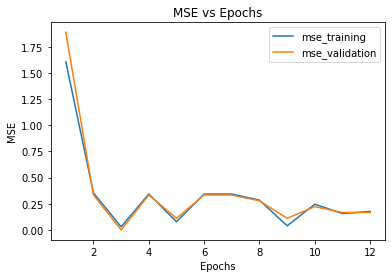

In [34]:
# Graph with MSE, epochs vs MSE(valid set, training set)
epochs = np.arange(1,mlp_iris.epoch_count+1)
plt.plot(epochs, mlp_iris.mse_training, label="mse_training")
plt.plot(epochs, mlp_iris.mse_valid, label="mse_validation")
plt.title("MSE vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend()
plt.show()

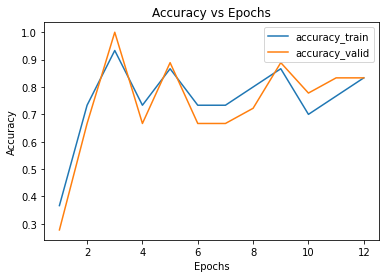

In [35]:
#Create graph with classification accuracy (% classified correctly) over epochs from the training set and validation set
plt.plot(epochs, mlp_iris.accuracy_train, label="accuracy_train")
plt.plot(epochs, mlp_iris.accuracy_valid, label="accuracy_valid")
plt.title("Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [36]:
# Test set Accuracy
print(mlp_iris.score(X_test, y_test))

0.9333333333333333


## 3. (10%) Working with the Vowel Dataset - Learning Rate

Load the Vowel Dataset [Vowel Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/vowel.arff)

- Use one layer of hidden nodes with the number of hidden nodes being twice the number of inputs.
- Use random 80/20 splits of the data for the training/test set.
- Use a validation set (15% of the training set) taken from the training set for your stopping criteria
- Try some different learning rates (LR). Note that each LR will probably require a different number of epochs to learn. 

- For each LR you test, plot their validation's set MSE over Epochs on the same graph. Graph 4-5 different LRs and make them different enough to see a difference between them.

In general, whenever you are testing a parameter such as LR, # of hidden nodes, etc., test values until no more improvement is found. For example, if 20 hidden nodes did better than 10, you would not stop at 20, but would try 40, etc., until you no longer get improvement.

If you would like you may average the results of multiple initial conditions (e.g. 3) per LR, and that obviously would give more accurate results.

<img src=https://raw.githubusercontent.com/cs472ta/CS472/master/images/backpropagation/backprop_val_set_MSE_vs_epochs.png width=500 height=500  align="left">

In [39]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Train on each dataset

vowel_data = arff.loadarff("vowel.arff")
vowel_df = pd.DataFrame(vowel_data[0])
vowel_df['Class'] = vowel_df['Class'].str.decode('utf-8')
vowel_df['Train or Test'] = vowel_df['Train or Test'].str.decode('utf-8')
vowel_df['Speaker Number'] = vowel_df['Speaker Number'].str.decode('utf-8')
vowel_df['Sex'] = vowel_df['Sex'].str.decode('utf-8')

ct = ColumnTransformer(transformers=[("encoder", OneHotEncoder(), ['Train or Test', 'Speaker Number', 'Sex'])], remainder="passthrough")
vowel_df = ct.fit_transform(vowel_df)

np_vowel = np.array(vowel_df)
X = np_vowel[:,:-1]
y = np_vowel[:,-1]
y = onehot_encoder.fit_transform(np.reshape(y,(y.shape[0],1)))

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

# Take the validation set
valid_index = int(len(X_train) * 0.15)
X_valid = X_train[:valid_index, :]
y_valid = y_train[:valid_index,:]
# Delete the validation set in the training sets
X_train = X_train[valid_index:,:]
y_train = y_train[valid_index:,:]

In [38]:
mlp_vowel_1 = MLPClassifier(0.01, 0, True, [58], False, True, False)
mlp_vowel_1.set_valid_sets(X_valid, y_valid)
mlp_vowel_1.set_test_sets(X_test, y_test)
mlp_vowel_1 = mlp_vowel_1.fit(X_train, y_train, 11)
mse_vowel_1 = mlp_vowel_1.mse_valid

done


In [40]:
mlp_vowel_2 = MLPClassifier(0.115, 0, True, [58], False, True, False)
mlp_vowel_2.set_valid_sets(X_valid, y_valid)
mlp_vowel_2.set_test_sets(X_test, y_test)
mlp_vowel_2 = mlp_vowel_2.fit(X_train, y_train, 11)
mse_vowel_2 = mlp_vowel_2.mse_valid

done


In [41]:
mlp_vowel_3 = MLPClassifier(0.3, 0, True, [58], False, True, False)
mlp_vowel_3.set_valid_sets(X_valid, y_valid)
mlp_vowel_3.set_test_sets(X_test, y_test)
mlp_vowel_3 = mlp_vowel_3.fit(X_train, y_train, 11)
mse_vowel_3 = mlp_vowel_3.mse_valid

done


In [42]:
mlp_vowel_4 = MLPClassifier(0.8, 0, True, [58], False, True, False)
mlp_vowel_4.set_valid_sets(X_valid, y_valid)
mlp_vowel_4.set_test_sets(X_test, y_test)
mlp_vowel_4 = mlp_vowel_4.fit(X_train, y_train, 11)
mse_vowel_4 = mlp_vowel_4.mse_valid

done


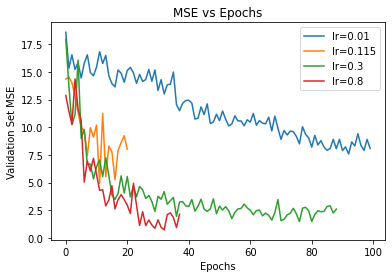

In [45]:
plt.plot(np.arange(0, len(mse_vowel_1)), mse_vowel_1, label="lr=0.01")
plt.plot(np.arange(0, len(mse_vowel_2)), mse_vowel_2, label="lr=0.115")
plt.plot(np.arange(0, len(mse_vowel_3)), mse_vowel_3, label="lr=0.3")
plt.plot(np.arange(0, len(mse_vowel_4)), mse_vowel_4, label="lr=0.8")
plt.title("MSE vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Validation Set MSE")
plt.legend()
plt.show()

## 3.1 (5%) Working with the Vowel Dataset - Intuition
- Discuss the effect of varying learning rates. 
- Discuss why the vowel data set might be more difficult than Iris
    - Report both datasets' baseline accuracies and best **test** set accuracies. 
- Consider which of the vowel dataset's given input features you should actually use (Train/test, speaker, gender, ect) and discuss why you chose the ones you did.

Typical backpropagation accuracies for the Vowel data set are above 75%.



In [44]:
print(mlp_vowel_1.score(X_test,y_test))
print(mlp_vowel_2.score(X_test,y_test))
print(mlp_vowel_3.score(X_test,y_test))
print(mlp_vowel_4.score(X_test,y_test))

0.6060606060606061
0.5808080808080808
0.9040404040404041
0.898989898989899


As I looked at the results, it seems that appropriate learning rate is critical for our models.
If learning rate is too small, our accuracy does not really improve, so it results in very low accuracy. If the learning rate is too big, then it also stops iterating with too big jumps.

Looking at the vowel dataset, the speaker column seems to have too many possible features, and I think that is one of the reasons this dataset is more difficult than the iris dataset.
I have run the iris model many times, and the accuracy was above 90% most of the time, and the best result was almost 100%. 
For the vowel dataset, the accuracy of the model with the very low learning rate was below 75%, but the baseline accuracy was around 78%, and got a best result of 96% with appropriate learning rate.

I think I would not use the speaker feature since it has too many variations in it, but I would use train/test, gender, and other features to train our model.



## 3.2 (10%) Working with the Vowel Dataset - Hidden Layer Nodes

Using the best LR you discovered, experiment with different numbers of hidden nodes.

- Start with 1 hidden node, then 2, and then double them for each test until you get no more improvement in accuracy. 
- For each number of hidden nodes find the best validation set solution (in terms of validation set MSE).  
- Create one graph with MSE for the training set and validation set on the y-axis and # of hidden nodes on the x-axis.
- Report the final test set accuracy for every # of hidden nodes you experimented on

In [46]:
# Using LR as 0.3

node = 0
acc=[]
min_mse_valid=[]
min_mse_train=[]
while True:
    hidden_node = pow(2, node)
    mlp_hidden = MLPClassifier(0.3, 0, True, [hidden_node], False, True, False)
    mlp_hidden.set_valid_sets(X_valid, y_valid)
    mlp_hidden.set_test_sets(X_test, y_test)
    mlp_hidden = mlp_hidden.fit(X_train, y_train, 11)
    min_mse_valid.append(min(mlp_hidden.mse_valid))
    min_mse_train.append(min(mlp_hidden.mse_training))
    acc.append(mlp_hidden.score(X_test, y_test))
    if len(acc) >= 3:
        if acc[len(acc)-1] <= acc[len(acc)-2]:
            break
    node +=1 

done
done
done
done
done


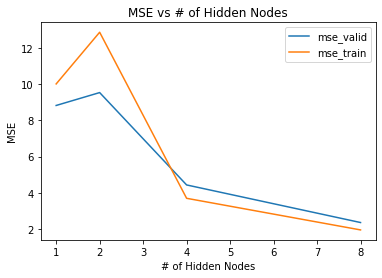

In [47]:
# MSE vs # of hidden nodes
hidden_x=[]
for i in range(node):
    hidden_x.append(pow(2,i))
plt.plot(hidden_x, min_mse_valid[:-1], label="mse_valid")
plt.plot(hidden_x, min_mse_train[:-1], label="mse_train")
plt.legend()
plt.title("MSE vs # of Hidden Nodes")
plt.xlabel("# of Hidden Nodes")
plt.ylabel("MSE")
plt.show()

In [48]:
# Report final test accuracy
acc= acc[:-1]
for i in range(len(acc)):
    print("# of Hidden nodes = ", hidden_x[i], " Accuracy = ", acc[i])

# of Hidden nodes =  1  Accuracy =  0.1414141414141414
# of Hidden nodes =  2  Accuracy =  0.2676767676767677
# of Hidden nodes =  4  Accuracy =  0.6666666666666666
# of Hidden nodes =  8  Accuracy =  0.803030303030303


*Discuss Hidden Layer Nodes here*



## 3.3 (10%) Working with the Vowel Dataset - Momentum

Try some different momentum terms using the best number of hidden nodes and LR from your earlier experiments.

- Create a graph similar to step 3.2, but with momentum on the x-axis and number of epochs until validation set convergence on the y-axis.
- You are trying to see how much momentum speeds up learning. 

In [49]:
# LR of 0.4 and # of Hidden Node: 16
import warnings
warnings.filterwarnings('ignore')

momentum=0.2
num_epochs=[]
for _ in range(6):
    hidden_node = pow(2, node)
    mlp_momentum = MLPClassifier(0.4, momentum, True, [16], False, True, False)
    mlp_momentum.set_valid_sets(X_valid, y_valid)
    mlp_momentum.set_test_sets(X_test, y_test)
    mlp_momentum = mlp_momentum.fit(X_train, y_train, 11)
    num_epochs.append(mlp_momentum.epoch_count)
    
    momentum += 0.2

done
done
done
done
done
done


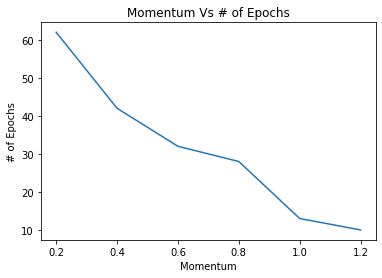

In [50]:
mom = np.arange(0.2, len(num_epochs)*0.2, 0.2)
plt.plot(mom, num_epochs)
plt.title("Momentum Vs # of Epochs")
plt.xlabel("Momentum")
plt.ylabel("# of Epochs")
plt.show()

It is clear that there were less number of epochs to run when the momemtum was higher. This is because the higher momentum speeds up the learning. The slide says the common rate for momentum is 0.9, and I could see that the number of epochs was the lowest around the momentum of 0.9 or 1.0. 



## 4.1 (10%) Use the scikit-learn (SK) version of the MLP classifier on the Iris and Vowel data sets.  

You do not need to go through all the steps above, nor graph results. Compare results (accuracy and learning speed) between your version and theirs for some selection of hyper-parameters. Try different hyper-parameters and comment on their effect.

At a minimum, try

- number of hidden nodes and layers
- different activation functions
- learning rate
- regularization and parameters
- momentum (and try nesterov)
- early stopping

In [51]:
from sklearn.neural_network import MLPClassifier

# Iris data set
np_iris
X = np_iris[:,:-1]
y = np_iris[:,-1]
y = np.asarray(y, dtype=np.int8)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

iris_clf = MLPClassifier(hidden_layer_sizes=20, max_iter=1000, alpha=0.0001, learning_rate_init=0.15, activation='tanh', momentum=0.9, early_stopping=False)
iris_clf.fit(X_train, y_train)
print("Iris dataset MLP score : " , iris_clf.score(X_test, y_test))

Iris dataset MLP score :  0.9666666666666667


In [52]:
# Train on voting dataset
X = np_vowel[:,:-1]
y = np_vowel[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
vowel_clf = MLPClassifier(hidden_layer_sizes=50, max_iter=1000, alpha=0.0001, learning_rate_init=0.1, activation='tanh', momentum=0.9, early_stopping=False)
vowel_clf.fit(X_train, y_train)
print("Vowel dataset MLP score : " , vowel_clf.score(X_test, y_test))

Vowel dataset MLP score :  0.9494949494949495


The score on the iris dataset was pretty similar to my model, but the sklearn's MLP score on the vowel dataset was more stable.
For number of hidden nodes and layers, I tried different numbers for the layers but it improved the accruacy sometimes, but not every time. I think it depends on how complex our problem is and on other things. Too small numbers for the hidden nodes gave low accuracy score, so appropriate hidden number of nodes was needed.
I tried tanh, relu, logistic, and identity, and I decided to use tan hyperbolic function for the activation function since it gave the best result among those.
For learning rate, about 0.1-0.2 was right since the rate higher than that gave worse accuracy scores. Also, I tried to differentiate the alpha rate for varying regularization but very small alpha rate was needed. I tried different momentum rate and decided to use 0.9, and also tried the early stopping as true, but the accuracy score was not very good, so I decided to not use the early stopping tool.

## 4.2 (5%) Using the Iris Dataset automatically adjust hyper-parameters using your choice of grid/random search
- Use a grid or random search approach across a reasonable subset of hyper-parameters from the above 
- Report your best accuracy and hyper-parameters. 

In [53]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Grid Search
iris = MLPClassifier(max_iter=1000)
X = np_iris[:,:-1]
y = np_iris[:,-1]
y = np.asarray(y, dtype=np.int8)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
space = {
    'hidden_layer_sizes' : [(50,50,50,),(100,),(20,)],
    'activation' : ['tanh', 'logistic','relu'],
    'momentum' : [0.3, 0.7, 0.9],
    'learning_rate': ['constant','adaptive'],
    'learning_rate_init' : [0.1,0.3,0.5]
}
clf = GridSearchCV(iris, space, n_jobs=-1, cv=3)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [54]:
# Report best accuracy and params
print("Best parameters :")
for param in clf.best_params_.keys():
    print("\t",param, " : ", clf.best_params_[param])
print("Report:")
print(classification_report(y_test, y_pred))

Best parameters :
	 activation  :  tanh
	 hidden_layer_sizes  :  (100,)
	 learning_rate  :  constant
	 learning_rate_init  :  0.1
	 momentum  :  0.7
Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        10

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



## 5. (Optional 5% Extra credit) For the vowel data set, use the other hyper-parameter approach that you did not use in part 4.2 to find LR, # of hidden nodes, and momentum.  

- Compare and discuss the values found with the ones you found in part 3.


In [57]:
from sklearn.model_selection import RandomizedSearchCV

# Random search
np_vowel = np.array(vowel_df)
X = np_vowel[:,:-1]
y = np_vowel[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

space = {
    'hidden_layer_sizes' : [(50,100,50,),(100,),(50,)],
    'activation' : ['tanh', 'logistic','relu'],
    'momentum' : [0.3, 0.7, 0.9],
    'learning_rate': ['constant','adaptive'],
    'learning_rate_init' : [0.1,0.3,0.5]
}

vowel = MLPClassifier(max_iter=1000)
clf = RandomizedSearchCV(vowel, space, n_jobs=-1, cv=2)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [58]:
# Report best accuracy and params
print("Best parameters :")
for param in clf.best_params_.keys():
    print("\t",param, " : ", clf.best_params_[param])
print("Report:")
print(classification_report(y_test, y_pred))

Best parameters :
	 momentum  :  0.9
	 learning_rate_init  :  0.1
	 learning_rate  :  adaptive
	 hidden_layer_sizes  :  (100,)
	 activation  :  relu
Report:
              precision    recall  f1-score   support

         hAd       1.00      0.71      0.83        14
         hEd       0.95      1.00      0.98        20
         hId       1.00      0.95      0.98        21
         hOd       0.90      1.00      0.95        19
         hUd       0.81      1.00      0.89        17
         hYd       0.89      0.94      0.91        17
         had       0.82      0.88      0.85        16
         hed       0.93      1.00      0.97        14
         hid       1.00      1.00      1.00        20
         hod       1.00      0.95      0.97        19
         hud       1.00      0.81      0.89        21

    accuracy                           0.93       198
   macro avg       0.94      0.93      0.93       198
weighted avg       0.94      0.93      0.93       198



First of all, the best activation function found was different than the sigmoid function. The random search found 'relu' to be the best which is the rectified linear unif function.
From part 3.3, I found the momentum rate of about 0.9 was the fit, and the search method found it also as 0.9. The hidden layer sizes was more than I used in part 3, and the same adaptive learning rate as 0.1. Overall, I think the accuracy score was better from the parameters that the random search found than mine.